## 1 - Simple regression model in TensorFlow 2.0

Let's get some data from the cars data set!

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/anglin/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Now that we have some data, we need to go about cleaning it.

In [4]:
# Drop NA values
dataset = dataset.dropna()

In [5]:
# We need to turn origin into a one-hot encoded vector.

origin = dataset.pop('Origin')

In [6]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


 Split the data set into a train/test split

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Explore data

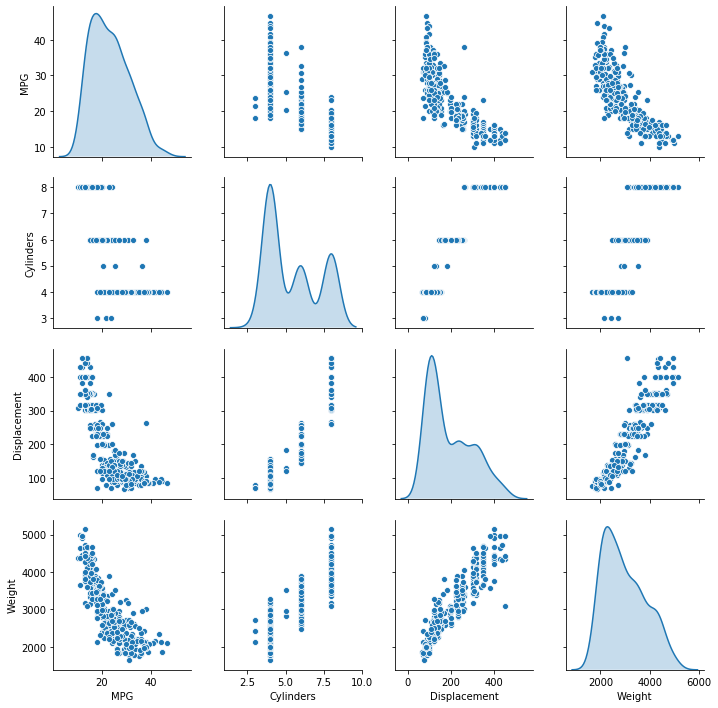

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normal-transform data set for use in a regression network.

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Do it probabilistically!

Going to replace the first `Dense` layer with one that's probabilistic.

In [12]:
def build_model():
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [13]:
model = build_model()

TypeError: __init__() missing 2 required positional arguments: 'make_posterior_fn' and 'make_prior_fn'

## Well, not that easy.

In [14]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [15]:
def build_model():
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', 
                                    input_shape=[len(train_dataset.keys())], 
                                    make_posterior_fn=posterior_mean_field, 
                                    make_prior_fn=prior_trainable),
        tfp.layers.DenseVariational(64, activation='relu',
                                    make_posterior_fn=posterior_mean_field, 
                                    make_prior_fn=prior_trainable),
        tfp.layers.DenseVariational(1,
                                    make_posterior_fn=posterior_mean_field, 
                                    make_prior_fn=prior_trainable),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 64)                1920      
_________________________________________________________________
dense_variational_1 (DenseVa (None, 64)                12480     
_________________________________________________________________
dense_variational_2 (DenseVa (None, 1)                 195       
Total params: 14,595
Trainable params: 14,595
Non-trainable params: 0
_________________________________________________________________


In [51]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[23.081028],
       [23.081028],
       [23.081028],
       [23.081028],
       [23.081028],
       [23.081028],
       [23.081028],
       [23.081028],
       [23.081028],
       [23.081028]], dtype=float32)

In [23]:
model.layers

In [27]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10000 == 0: 
            print('')
        if epoch % 1000 == 0:
            print('.', end='')

EPOCHS = 100_000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..........

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,90.421072,6.363264,62.569462,90.311878,6.296671,58.004387,9995
9996,85.266352,6.352773,58.786388,92.252646,6.612972,61.820419,9996
9997,87.913740,6.438983,59.804970,95.121832,6.656537,62.551781,9997
9998,93.373534,6.768645,67.955452,88.757464,6.534748,61.636143,9998
9999,81.150959,6.249733,56.363171,77.821487,6.606434,61.503555,9999


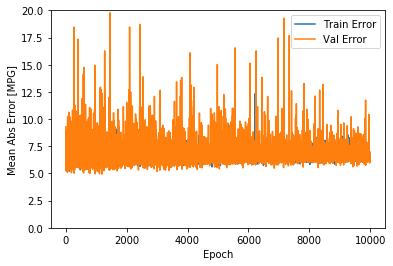

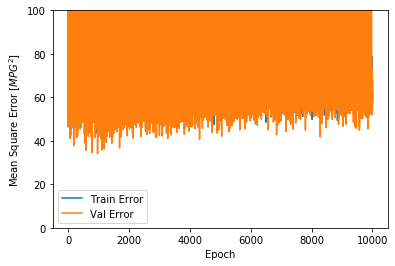

In [30]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,100])
    plt.legend()
    plt.show()


plot_history(history)

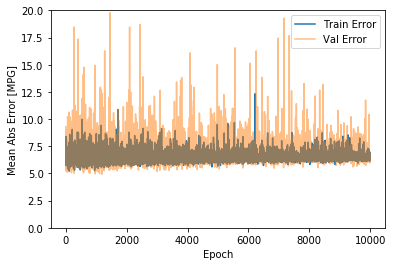

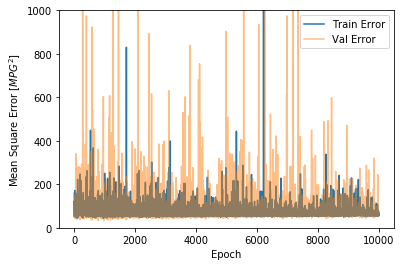

In [34]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], alpha=0.5,
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], alpha=0.5,
           label = 'Val Error')
    plt.ylim([0,1000])
    plt.legend()
    plt.show()


plot_history(history)

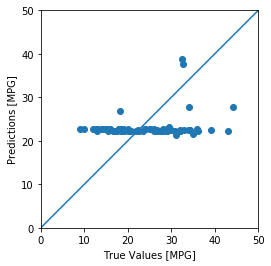

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [36]:
yhats = [model.predict(normed_test_data).flatten() for _ in range(100)]

In [37]:
yhat_mean = pd.DataFrame(yhats).mean().values

In [38]:
df = pd.DataFrame(yhats).T
df['y'] = test_labels.values

In [39]:
import itertools

buncha_preds = list(itertools.chain.from_iterable([[(j, x[-1]) for j in x if j != x[-1]] for x in df.values]))

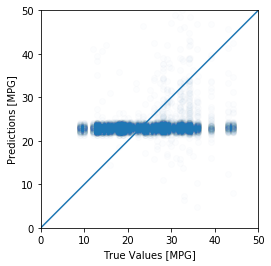

In [44]:
a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in buncha_preds], [x[0] for x in buncha_preds], alpha=0.01)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

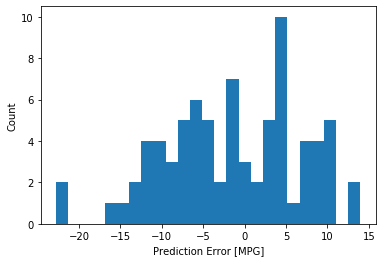

In [41]:
test_predictions = model.predict(normed_test_data).flatten()
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

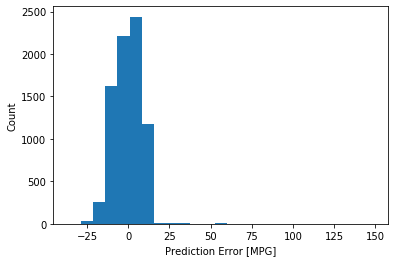

In [42]:
test_predictions = model.predict(normed_test_data).flatten()
error = [x[0] - x[1] for x in buncha_preds]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")